# **Implement a Collaborative Similarity Function between Items**

---

In [17]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
DATA_DIR = Path() / "data"
DATASETS_NAME = "hetrec2011-movielens-2k-v2"


In [3]:
user_rated_movies = pd.read_csv(
    DATA_DIR / DATASETS_NAME / "user_ratedmovies-timestamps.dat",
    sep="\t",
    encoding="utf-8",
)
user_rated_movies.head(n=5)

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [4]:
movies = pd.read_csv(
    DATA_DIR / DATASETS_NAME / "movies.dat",
    sep="\t",
    encoding="latin-1",
)
movies.head(n=5)

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [5]:
# Get the ids of the movies we are interested in
movie_names = [
    "The Matrix",
    "Alien",
    "The Godfather",
]

movie_ids = movies[movies["title"].isin(movie_names)][["id", "title"]].to_dict(orient="records")
movie_ids


[{'id': 858, 'title': 'The Godfather'},
 {'id': 1214, 'title': 'Alien'},
 {'id': 2571, 'title': 'The Matrix'},
 {'id': 25934, 'title': 'The Godfather'}]

In [6]:
# Get the movies we are interested in
interested_movies = user_rated_movies[
    user_rated_movies["movieID"].isin(movies[movies["title"].isin(movie_names)]["id"])
]
interested_movies.head(n=5)

,userID,movieID,rating,timestamp
29,75,2571,4.5,1162161050000
98,78,858,4.0,1089332870000
149,78,1214,5.0,1083963994000
286,78,2571,5.0,1083964044000
612,170,2571,3.5,1162208300000


In [7]:
merged_movies = interested_movies.merge(movies[["id", "title"]], left_on="movieID", right_on="id")
merged_movies.head(n=5)

,userID,movieID,rating,timestamp,id,title
0,75,2571,4.5,1162161050000,2571,The Matrix
1,78,858,4.0,1089332870000,858,The Godfather
2,78,1214,5.0,1083963994000,1214,Alien
3,78,2571,5.0,1083964044000,2571,The Matrix
4,170,2571,3.5,1162208300000,2571,The Matrix


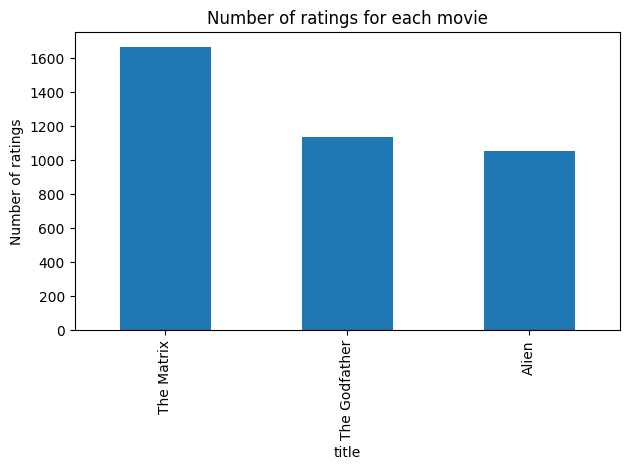

In [8]:
# Count the number of ratings for each movie
merged_movies["title"].value_counts().plot(kind="bar")
plt.title("Number of ratings for each movie")
plt.ylabel("Number of ratings")
plt.tight_layout();

In [10]:
# The average rating for each movie
merged_movies.groupby("title")[["rating"]].mean()

,rating
title,
Alien,3.957940
The Godfather,4.334507
The Matrix,4.173952


In [11]:
# Create a sparse matrix
user_ratings = merged_movies.pivot_table(index="title", columns="userID", values="rating").fillna(0)
user_ratings

userID,75,78,170,175,190,267,325,383,476,477,...,71331,71420,71478,71483,71487,71497,71509,71525,71529,71534
title,,,,,,,,,,,,,,,,,,,,,
Alien,0.0,5.0,0.0,5.0,3.5,4.0,5.0,4.0,4.5,4.5,...,0.0,3.0,0.0,4.0,0.0,4.0,0.0,5.0,0.0,0.0
The Godfather,0.0,4.0,0.0,5.0,1.0,2.5,5.0,4.0,0.0,5.0,...,0.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0
The Matrix,4.5,5.0,3.5,5.0,5.0,4.0,0.0,4.0,4.5,4.5,...,5.0,5.0,0.0,4.0,5.0,5.0,3.5,5.0,2.5,4.5


In [12]:
# Calculate fill the zero rating for each column the average rating for each user
user_ratings.apply(lambda x: x.replace(0, x.mean()), axis=0)

userID,75,78,170,175,190,267,325,383,476,477,...,71331,71420,71478,71483,71487,71497,71509,71525,71529,71534
title,,,,,,,,,,,,,,,,,,,,,
Alien,1.5,5.0,1.166667,5.0,3.5,4.0,5.000000,4.0,4.5,4.5,...,1.666667,3.0,1.666667,4.0,3.333333,4.0,2.833333,5.0,0.833333,3.166667
The Godfather,1.5,4.0,1.166667,5.0,1.0,2.5,5.000000,4.0,3.0,5.0,...,1.666667,4.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,0.833333,5.000000
The Matrix,4.5,5.0,3.500000,5.0,5.0,4.0,3.333333,4.0,4.5,4.5,...,5.000000,5.0,1.666667,4.0,5.000000,5.0,3.500000,5.0,2.500000,4.500000


In [13]:
pd.DataFrame(cosine_similarity(user_ratings), index=user_ratings.index, columns=user_ratings.index)


title,Alien,The Godfather,The Matrix
title,,,
Alien,1.000000,0.662640,0.725019
The Godfather,0.662640,1.000000,0.711057
The Matrix,0.725019,0.711057,1.000000


In [24]:
def item_similarity(ratings, item_i, item_j):
    """
    Compute the similarity between two items using mean-centered ratings.

    Parameters:
    - ratings: A 2D numpy array where rows represent users and columns represent items.
    - item_i: Index of the first item.
    - item_j: Index of the second item.

    Returns:
    - similarity: The cosine similarity between the two items.
    """
    # Calculate the average rating for each user (ignoring NaN values)
    user_means = np.nanmean(ratings, axis=1)

    # Center the ratings by subtracting the user's mean rating
    centered_ratings = ratings - user_means[:, np.newaxis]

    # Get the ratings for the two items, centered by the user's mean
    item_i_ratings = centered_ratings[:, item_i]
    item_j_ratings = centered_ratings[:, item_j]

    # Remove NaN values (ratings that don't exist)
    valid_users = ~np.isnan(item_i_ratings) & ~np.isnan(item_j_ratings)
    item_i_ratings = item_i_ratings[valid_users]
    item_j_ratings = item_j_ratings[valid_users]

    # Compute the numerator (dot product)
    numerator = np.dot(item_i_ratings, item_j_ratings)

    # Compute the denominator (product of magnitudes)
    denom_i = np.sqrt(np.dot(item_i_ratings, item_i_ratings))
    denom_j = np.sqrt(np.dot(item_j_ratings, item_j_ratings))

    # Return the cosine similarity (if denominator is zero, return 0)
    if denom_i == 0 or denom_j == 0:
        return 0
    else:
        return numerator / (denom_i * denom_j)

In [26]:
for i, movie_i in enumerate(movie_names):
    for j, movie_j in enumerate(movie_names):
        if i < j:
            similarity = item_similarity(user_ratings.values, i, j)
            print(f"The similarity between '{movie_i}' and '{movie_j}' is {similarity:.4f}.")

The similarity between 'The Matrix' and 'Alien' is -0.7686.
The similarity between 'The Matrix' and 'The Godfather' is 0.9612.
The similarity between 'Alien' and 'The Godfather' is -0.8815.


In [21]:
pd.DataFrame(pairwise_distances(
    user_ratings.values,
    metric="jaccard",
), index=user_ratings.index, columns=user_ratings.index)

C:\Users\Sudad-ABDULRAZZAQ\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


title,Alien,The Godfather,The Matrix
title,,,
Alien,0.000000,0.498630,0.428571
The Godfather,0.498630,0.000000,0.435268
The Matrix,0.428571,0.435268,0.000000


In [23]:
pd.DataFrame(pairwise_distances(
    user_ratings.values,
    metric="correlation",
), index=user_ratings.index, columns=user_ratings.index)

title,Alien,The Godfather,The Matrix
title,,,
Alien,0.000000,0.799028,0.882859
The Godfather,0.799028,0.000000,1.076403
The Matrix,0.882859,1.076403,0.000000
